In [1]:
import shap
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
# load JS visualization code to notebook
shap.initjs()
from scipy.stats import pearsonr

# load data

In [2]:
configs = json.load(open("../configs/shap/shap_multi_drug_ic50norm.json", 'r'))
meta_file = '../data/E0022_P06_final_sample_map_no_control.txt'
data_file = '../data/protein/E0022_P06_Protein_Matrix_ProNorM_no_control.txt'
ic50_file = '../data/drug/ic50_processed.csv'
cell_lines_train_file = '../data/protein/E0022_P06_Protein_Matrix_ProNorM_no_control_train.txt'
cell_lines_test_file = '../data/protein/E0022_P06_Protein_Matrix_ProNorM_no_control_test.txt'
seed = 42

In [3]:
min_cell_lines = 300

In [4]:
meta = pd.read_csv(meta_file, sep='\t')
ic50 = pd.read_csv(ic50_file)
ic50 = ic50.sort_values(by=['Dataset version'])
ic50 = ic50.drop_duplicates(
    ['Drug Id', 'Cell line name'], keep='last').sort_values(
        by=['Drug Id', 'Cell line name']).reset_index(drop=True)
ic50_counts = ic50.groupby(['Drug Id']).size()
selected_drugs = ic50_counts[ic50_counts > min_cell_lines].index.values

# selected_drugs = [257]

ic50_selected = ic50[ic50['Drug Id'].isin(selected_drugs)]
ic50_selected_pivot = pd.pivot(
    ic50_selected[['Cell line name', 'Drug Id', configs['target']]],
    index='Cell line name',
    columns='Drug Id',
    values=configs['target']).reset_index()

ic50_selected_pivot = ic50_selected_pivot.sort_values(
    by=['Cell line name']).reset_index(drop=True)

data_sample = pd.read_csv(data_file, sep='\t')

cell_lines_train = pd.read_csv(cell_lines_train_file, sep='\t')['Cell_line'].values
cell_lines_test = pd.read_csv(cell_lines_test_file, sep='\t')['Cell_line'].values


ic50_selected_pivot_train = ic50_selected_pivot[
    ic50_selected_pivot['Cell line name'].isin(cell_lines_train)].reset_index(
        drop=True)
ic50_selected_pivot_test = ic50_selected_pivot[
    ic50_selected_pivot['Cell line name'].isin(cell_lines_test)].reset_index(
        drop=True)

num_of_proteins = data_sample.shape[1] - 1

data_sample_train = data_sample[data_sample['Cell_line'].isin(
    cell_lines_train)].reset_index(drop=True)
data_sample_test = data_sample[data_sample['Cell_line'].isin(
    cell_lines_test)].reset_index(drop=True)

merged_df_train = pd.merge(data_sample_train,
                           ic50_selected_pivot_train,
                           left_on=['Cell_line'],
                           right_on=['Cell line name'
                                     ]).drop(['Cell line name'], axis=1)
merged_df_test = pd.merge(data_sample_test,
                          ic50_selected_pivot_test,
                          left_on=['Cell_line'],
                          right_on=['Cell line name']).drop(['Cell line name'],
                                                            axis=1)

train_df = merged_df_train.iloc[:, 1:(num_of_proteins + 1)]
train_ic50 = merged_df_train.iloc[:, (num_of_proteins + 1):]
test_ic50 = merged_df_test.iloc[:, (num_of_proteins + 1):]
test_df = merged_df_test.iloc[:, 1:(num_of_proteins + 1)]

merged_df_all = pd.merge(data_sample,
                         ic50_selected_pivot,
                         left_on=['Cell_line'],
                         right_on=['Cell line name']).drop(['Cell line name'],
                                                           axis=1)
all_df = merged_df_all.iloc[:, 1:(num_of_proteins + 1)]
all_ic50 = merged_df_all.iloc[:, (num_of_proteins + 1):]

# process shap

## prepare

In [2]:
configs = json.load(open("../configs/shap/shap_multi_drug_ic50norm.json", 'r'))
meta_file = '../data/E0022_P06_final_sample_map_no_control.txt'
data_file = '../data/protein/E0022_P06_Protein_Matrix_ProNorM_no_control_update.txt'
ic50_file = '../data/drug/drug_final_processed.csv.gz'
cell_lines_train_file = '../data/protein/E0022_P06_Protein_Matrix_ProNorM_no_control_train.txt'
cell_lines_test_file = '../data/protein/E0022_P06_Protein_Matrix_ProNorM_no_control_test.txt'
seed = 42

In [5]:
min_cell_lines = 300

In [7]:
meta = pd.read_csv(meta_file, sep='\t')
ic50 = pd.read_csv(ic50_file)

ic50_counts = ic50.groupby(['drug_id']).size()
selected_drugs = ic50_counts[ic50_counts > min_cell_lines].index.values

# selected_drugs = [257]

ic50_selected = ic50[ic50['drug_id'].isin(selected_drugs)]
ic50_selected_pivot = pd.pivot(
    ic50_selected[['cell_line_name', 'drug_id', configs['target']]],
    index='cell_line_name',
    columns='drug_id',
    values=configs['target']).reset_index()

ic50_selected_pivot = ic50_selected_pivot.sort_values(
    by=['cell_line_name']).reset_index(drop=True)

data_sample = pd.read_csv(data_file, sep='\t')

cell_lines_train = pd.read_csv(cell_lines_train_file, sep='\t')['Cell_line'].values
cell_lines_test = pd.read_csv(cell_lines_test_file, sep='\t')['Cell_line'].values


ic50_selected_pivot_train = ic50_selected_pivot[
    ic50_selected_pivot['cell_line_name'].isin(cell_lines_train)].reset_index(
        drop=True)
ic50_selected_pivot_test = ic50_selected_pivot[
    ic50_selected_pivot['cell_line_name'].isin(cell_lines_test)].reset_index(
        drop=True)

num_of_proteins = data_sample.shape[1] - 1

data_sample_train = data_sample[data_sample['Cell_line'].isin(
    cell_lines_train)].reset_index(drop=True)
data_sample_test = data_sample[data_sample['Cell_line'].isin(
    cell_lines_test)].reset_index(drop=True)

merged_df_train = pd.merge(data_sample_train,
                           ic50_selected_pivot_train,
                           left_on=['Cell_line'],
                           right_on=['cell_line_name'
                                     ]).drop(['cell_line_name'], axis=1)
merged_df_test = pd.merge(data_sample_test,
                          ic50_selected_pivot_test,
                          left_on=['Cell_line'],
                          right_on=['cell_line_name']).drop(['cell_line_name'],
                                                            axis=1)

train_df = merged_df_train.iloc[:, 1:(num_of_proteins + 1)]
train_ic50 = merged_df_train.iloc[:, (num_of_proteins + 1):]
test_ic50 = merged_df_test.iloc[:, (num_of_proteins + 1):]
test_df = merged_df_test.iloc[:, 1:(num_of_proteins + 1)]

merged_df_all = pd.merge(data_sample,
                         ic50_selected_pivot,
                         left_on=['Cell_line'],
                         right_on=['cell_line_name']).drop(['cell_line_name'],
                                                           axis=1)
all_df = merged_df_all.iloc[:, 1:(num_of_proteins + 1)]
all_ic50 = merged_df_all.iloc[:, (num_of_proteins + 1):]

In [8]:
drug_score = pd.read_csv("../data/drug/final_drug_scores.tsv", sep="\t")
drug_list = drug_score[
    (drug_score['MultiDrug_correlation'] > 0.4) & (drug_score['sensitive_count'] > 20)][
    'drug_id'].values

## IC50

In [39]:
shap_values = pickle.load(
    open(
        "../work_dirs/shap_protein/gradient_202006081705__resx_ruv_zero_300_test_70_202006111046_shap_0.pkl",
        "rb"))
index = pickle.load(
    open(
        "../work_dirs/shap_protein/gradient_202006081705__resx_ruv_zero_300_test_70_202006111046_indexes_0.pkl",
        "rb"))
index = index[:shap_values[0].shape[0]]

In [42]:
target = test_ic50.columns.get_loc(1114)

drug_index = np.argwhere(index == target)

res = []
for i in drug_index:
    res.append(shap_values[i[1]][i[0],:])
res = np.array(res)

res.shape

(100, 3425)

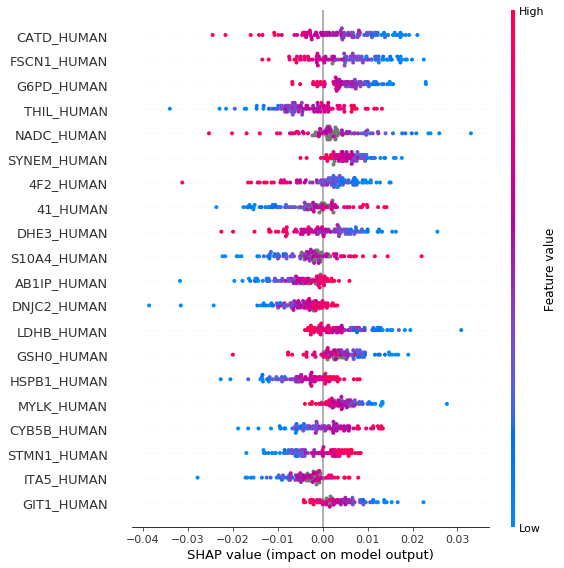

In [43]:
shap.summary_plot(res, test_df.iloc[drug_index[:, 0], :], max_display=20)

In [44]:
df = pd.DataFrame({
    'protein':
    test_df.columns
})

In [45]:
for drug_id in drug_list:
    target = test_ic50.columns.get_loc(drug_id)

    drug_index = np.argwhere(index == target)

    res = []
    for i in drug_index:
        res.append(shap_values[i[1]][i[0],:])
    res = np.array(res)

    df[f'importance_{drug_id}'] = np.average(np.abs(res),axis=0)

In [46]:
df.to_csv("../result_files/shap/test_70_202006111046.csv", index=False)

## growth

In [47]:
shap_values = pickle.load(
    open(
        "../work_dirs/shap_protein/gradient_202006081706__resx_ruv_zero_300_growth_corrected_test_25_202006111047_shap_0.pkl",
        "rb"))
index = pickle.load(
    open(
        "../work_dirs/shap_protein/gradient_202006081706__resx_ruv_zero_300_growth_corrected_test_25_202006111047_indexes_0.pkl",
        "rb"))
index = index[:shap_values[0].shape[0]]

In [48]:
target = test_ic50.columns.get_loc(1909)

drug_index = np.argwhere(index == target)

res = []
for i in drug_index:
    res.append(shap_values[i[1]][i[0],:])
res = np.array(res)

res.shape

(100, 3425)

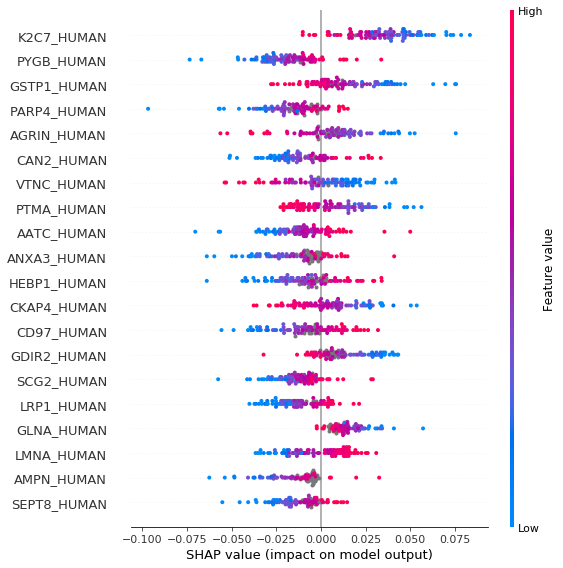

In [49]:
shap.summary_plot(res, test_df.iloc[drug_index[:, 0], :], max_display=20)

In [50]:
df = pd.DataFrame({
    'protein':
    test_df.columns
})

In [51]:
for drug_id in drug_list:
    target = test_ic50.columns.get_loc(drug_id)

    drug_index = np.argwhere(index == target)

    res = []
    for i in drug_index:
        res.append(shap_values[i[1]][i[0],:])
    res = np.array(res)

    df[f'importance_{drug_id}'] = np.average(np.abs(res),axis=0)

In [53]:
df.to_csv("../result_files/shap/test_25_202006111047_growth_corrected.csv", index=False)

## pc1 corrected

In [54]:
shap_values = pickle.load(
    open(
        "../work_dirs/shap_protein/gradient_202006081706__resx_ruv_zero_300_pc1_corrected_test_25_202006111047_shap_0.pkl",
        "rb"))
index = pickle.load(
    open(
        "../work_dirs/shap_protein/gradient_202006081706__resx_ruv_zero_300_pc1_corrected_test_25_202006111047_indexes_0.pkl",
        "rb"))
index = index[:shap_values[0].shape[0]]

In [55]:
target = test_ic50.columns.get_loc(1909)

drug_index = np.argwhere(index == target)

res = []
for i in drug_index:
    res.append(shap_values[i[1]][i[0],:])
res = np.array(res)

res.shape

(100, 3425)

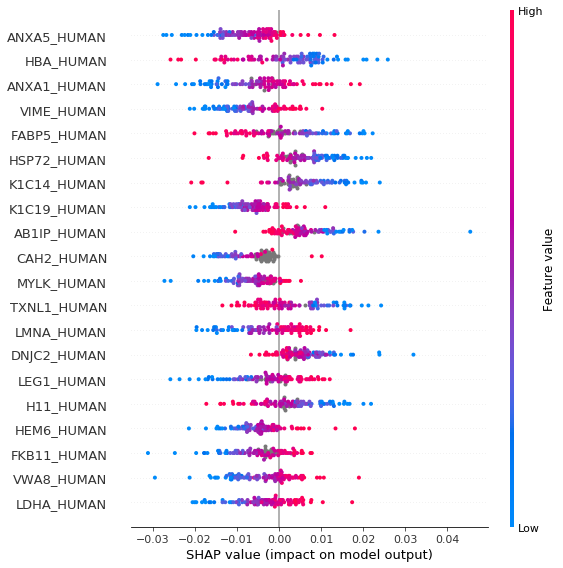

In [56]:
shap.summary_plot(res, test_df.iloc[drug_index[:, 0], :], max_display=20)

In [57]:
df = pd.DataFrame({
    'protein':
    test_df.columns
})

In [58]:
for drug_id in drug_list:
    target = test_ic50.columns.get_loc(drug_id)

    drug_index = np.argwhere(index == target)

    res = []
    for i in drug_index:
        res.append(shap_values[i[1]][i[0],:])
    res = np.array(res)

    df[f'importance_{drug_id}'] = np.average(np.abs(res),axis=0)

In [59]:
df.to_csv("../result_files/shap/test_25_202006111047_pc1_corrected.csv", index=False)